## functionality to check OpenStreetMap crossings

To understand hydraulic behaviour around bridges culverts and other objects that define how streets and waterways cross, we want to know where the type of crossing structure is mapped, where there is no structure (i.e. to cross you'll need to jump or walk around) and where this is not clear because no passing structure was mapped. 

We need to do a few things to establish this:
- filter out two sets of features (streets and waterways) from the Ramani Huria data. We use the agreed Ramani Huria data model to find these features. 
- locate where a feature in the set "streets" crosses with a feature in the set "waterways". Result is a list of pairs of features from "streets" and "waterways" that cross. 
- For each crossing, establish if a passing structure is mapped (e.g. tunnel=culvert or bridge=yes). 
- write the result to a shape file

We're testing this for the OSM data across Kigogo ward. If you only want to browse through the results, please scroll all the way down to the interactive map.


In [1]:
%matplotlib inline
from cartopy import crs
import cartopy
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.collections import PatchCollection

import numpy as np
import fiona
import shapely
from osm2dh import filter_features
from DFlowFM_tools import create_feature, add_properties
import logging
import rtree

below we collect all functions we need for this notebook. We refer to these later on

In [2]:
def plot_line(ax, ob, **kwargs):
    x, y = ob.xy
    ax.plot(x, y, **kwargs) 

def plot_bbox(ax, bbox, **kwargs):
    ax.plot(np.array(bbox)[[0, 2, 2, 0, 0]], np.array(bbox)[[1, 1, 3, 3, 1]], **kwargs)

def pair_crossings(feats_1, feats_2, buffer=0.0001):
    """
    Determines where features of one set cross with another, using spatial indexing
    """
    crossings = []
    all_feats = feats_1 + feats_2
    end_idx_1 = len(feats_1)  # last index of first feature set
    lines_bbox = [f['geometry'].buffer(buffer).bounds for f in all_feats]
    tree_idx = rtree.index.Index()
    for i, bbox in enumerate(lines_bbox):
        tree_idx.insert(i, bbox)
    # now go over each feature from feats_1 and check which features of feats_2 it intersects using spatial indexing
    for idx_1 in range(end_idx_1):
        feat_1 = all_feats[idx_1]
        hits = np.array(list(tree_idx.intersection(lines_bbox[idx_1])))
        hits_feats_2 = hits[hits >= end_idx_1]
        for idx_2 in hits_feats_2:
            intersections = [(feat_1, feat_2) for feat_2 in list(np.array(all_feats)[hits_feats_2]) if feat_2['geometry'].intersects(feat_1['geometry'])]
        crossings += intersections
    return crossings

def check_dict(props, key, value):
    """
    Checks if feature has a key value pair according to filter
    Returns: True or False
    """
    if key in props.keys():
        f = props[key]
    else:
        return False
    # filter on key/values

    if isinstance(value, str):
        # if value is empty strings, pass all objects of key (unless f return nothing)
        if value == '':
            if f in ['', None, '-1']:
                return False  # next feat
        # only matching key-value pairs
        else:
            if f != value:
                return False
    # check against multiple values
    elif isinstance(value, list):
        if f not in value:
            return False
    return True

def flag_crossing(pass_1, pass_2, struct_1='bridge', struct_2='tunnel'):
    if pass_1 & pass_2:
        struct = '{:s} and {:s}'.format(struct_1, struct_2)
        flag = 0
    elif pass_1:
        struct = struct_1
        flag = 0
    elif pass_2:
        struct = struct_2
        flag = 0
    else:
        struct = ''
        flag = 1
    return struct, flag

def crossings_collection(crossings, key_1, key_2, values_1, values_2, name_1='highway', name_2='waterway'):
    collection = []
    for c in crossings:
        ps = c[0]['geometry'].intersection(c[1]['geometry'])
        if isinstance(ps, shapely.geometry.LineString):
            ps = shapely.geometry.MultiPoint(zip(*ps.xy))
        elif isinstance(ps, shapely.geometry.Point):
            ps = [ps]
        # get all properties together
        props_1 = c[0]['properties']
        props_2 = c[1]['properties']
        pass_2 = check_dict(props_2, key_2, values_2)
        pass_1 = check_dict(props_1, key_1, values_1)
        struct, flag = flag_crossing(pass_1, pass_2)

        props_cross = {'osm_id_{:s}'.format(name_1) : props_1['osm_id'],
                       'osm_id_{:s}'.format(name_2) : props_2['osm_id'],
                       'flag' : flag,
                       'structure' : struct,
                      }
        for n, p in enumerate(ps):
#             print n
            collection.append(create_feature(p, **props_cross))
    return collection

First, collect all waterways and streets following the Ramani Huria data model. We use the function "filter_features" from our set of quality control routines to check this.

In [3]:
osm_fn = r'd:\test\kigogo.osm'

# define filter for waterways
key_1 = 'waterway'
values_1 = ['ditch', 'drain', 'stream', 'river']

# define filter for streets
key_2 = 'highway'
values_2 = ['primary', 'secondary', 'tertiary', 'residential']

# define filter for bridges
key_bridge = 'bridge'
values_bridge = ['yes', 'viaduct']


# define filter for culverts
key_culvert = 'tunnel'
values_culvert = ['culvert']

waterways = filter_features(osm_fn,
                            key=key_1,
                            value=values_1,
                            layer_index=1,
                            wgs2utm=False,
                            logger=logging,
                            bbox=None,
                            )

streets = filter_features(osm_fn,
                          key=key_2,
                          value=values_2,
                          layer_index=1,
                          wgs2utm=False,
                          logger=logging,
                          bbox=None,
                          )


In [4]:
print('We have {:d} waterways and {:d} streets across Kigogo ward'.format(len(waterways), len(streets)))

all_features = streets + waterways
print('Total features: {:d}'.format(len(all_features)))

We have 1228 waterways and 445 streets across Kigogo ward
Total features: 1673


Let's make a simple plot

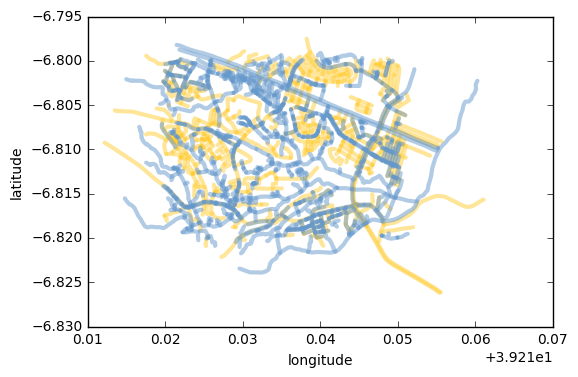

In [5]:
BLUE = '#6699cc'
YELLOW = '#ffcc33' 

# set upa figure
fig = plt.figure()
ax = plt.subplot(111)

# first plot streets
x = [plot_line(ax, ob['geometry'], color=YELLOW, alpha=0.5, linewidth=3, solid_capstyle='round', zorder=2) for ob in streets]
# then plot waterways
y = [plot_line(ax, ob['geometry'], color=BLUE, alpha=0.5, linewidth=3, solid_capstyle='round', zorder=2) for ob in waterways]

plt.xlabel('longitude')
plt.ylabel('latitude')    


now we make a list of bounding boxes per feature, so that we can perform spatial indexing in the features

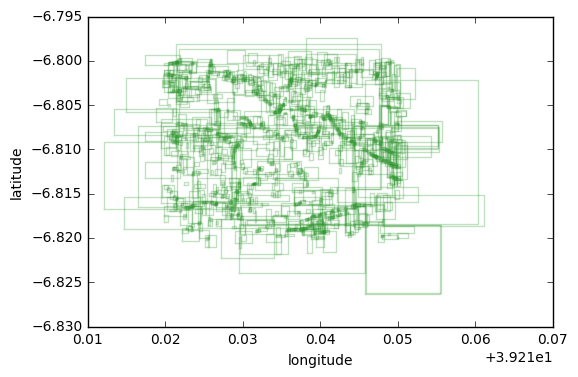

In [6]:
GREEN =  '#339933'
lines_bbox = [f['geometry'].buffer(0.0001).bounds for f in all_features]

## 
coll = [plt.plot(np.array(line)[[0, 2, 2, 0, 0]], np.array(line)[[1, 1, 3, 3, 1]], color=GREEN, alpha=0.3) for line in lines_bbox]
plt.xlabel('longitude')
plt.ylabel('latitude')

looks good, let's build spatial indexing with rtree to perform spatial indexing and selecting

In [7]:
tree_idx   = rtree.index.Index()
for i, bbox in enumerate(lines_bbox):
    tree_idx.insert(i, bbox)


test if we can find the appropriate waterways, that are within bounds of a given street (we tested and the 4th street gives some crossings)

In [8]:
end_idx = len(streets)
selected_id = 4
street = all_features[selected_id]
hits = np.array(list(tree_idx.intersection(lines_bbox[selected_id])))

# we are only interested in the ones that are a waterway, these start at end_idx, so loose the ones that are below end_idx
hits_waterways = hits[hits >= end_idx]
print hits_waterways

[ 758  757  787  786  752  753  737  748  764  736  749  785  750  754  751
  755  788  789  790  791  897  964  994  995  997  999 1000  528  765  747
  931  933]


let's plot the particular street and waterways and see if it makes sense

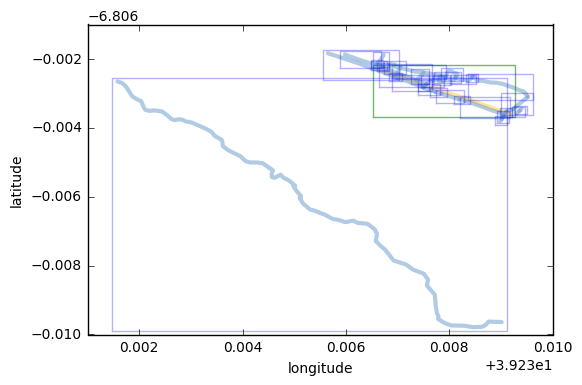

In [9]:
BLUE = '#6699cc'
YELLOW = '#ffcc33' 

f = plt.figure()
ax = f.add_subplot(111)

line = lines_bbox[selected_id]
plot_bbox(ax, line, color=GREEN, alpha=0.7, zorder=2)
# plot the selected street
plot_line(ax, street['geometry'], color=YELLOW, alpha=0.5, linewidth=3, solid_capstyle='round', zorder=1)
# then plot waterways
w = [plot_line(ax, ob['geometry'], color=BLUE, alpha=0.5, linewidth=3, solid_capstyle='round', zorder=1) for ob in list(np.array(all_features)[hits_waterways])]

# plot the bboxes of waterways
wb = [plot_bbox(ax, line, color='b', alpha=0.3) for line in list(np.array(lines_bbox)[hits_waterways])]
plt.xlabel('longitude')
plt.ylabel('latitude')    

looks very good and as expected, now we need to find which features really cross (if any) and add these to a pair list. We need to do this for all streets. We prepare a function for this called "pair_crossings". find the corresponding waterway and put these together in a list of tuples (pairs waterway/street). The function is in our list of functions above.


In [10]:
crossings = pair_crossings(streets, waterways)


Let's have a visual of all crossings. We use an alpha level to show which elements have multiple crossing (darker = more crossings)


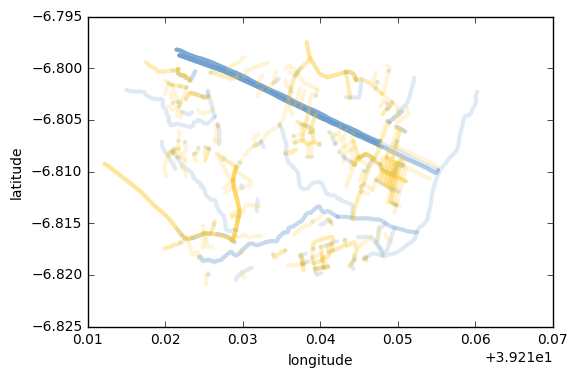

In [11]:
streets_cross, waterways_cross = zip(*crossings)
BLUE = '#6699cc'
YELLOW = '#ffcc33' 

# set upa figure
fig = plt.figure()
ax = plt.subplot(111)

# first plot streets
x = [plot_line(ax, ob['geometry'], color=YELLOW, alpha=0.2, linewidth=3, solid_capstyle='round', zorder=2) for ob in streets_cross]
# then plot waterways
y = [plot_line(ax, ob['geometry'], color=BLUE, alpha=0.2, linewidth=3, solid_capstyle='round', zorder=1) for ob in waterways_cross]

plt.xlabel('longitude')
plt.ylabel('latitude')    

now we need the intersections, and collect the attributes of each intersection so that a traceback can be done on the data. Any Line elements or multipoint elements are conveniently exploded to points, carrying all the attributes, so that you can always track these back on a map anywhere where a crossing appears.

In [12]:
cross_points = crossings_collection(crossings, key_bridge, key_culvert, values_bridge, values_culvert)


cross_points is our set of cross points with attributes. Let us now see what we are facing by making an interactive visualization. You can zoom in and out of the plot. We have added the WMTS tile server with the Ramani Huria drone images so that you can find out what's going on.

In [13]:
from bokeh.plotting import figure, show
from bokeh.models.tiles import WMTSTileSource
from bokeh.io import output_notebook, push_notebook
from pyproj import Proj, transform
from bokeh.models import ColumnDataSource, HoverTool, Div, ColorBar, LinearColorMapper, TapTool, CustomJS
from bokeh.palettes import Category10
colors = [Category10[3][-1], Category10[3][-2]]
color_mapper = LinearColorMapper(low=0, high=1, palette=colors)

def make_point_cds_WMTS(point_feats):
    outProj = Proj(init='epsg:3857')
    inProj = Proj(init='epsg:4326')
    df = {}
    df['x'], df['y'] = zip(*[transform(inProj, outProj, c['geometry'].xy[0][0], c['geometry'].xy[1][0]) for c in point_feats])
    for key in point_feats[0]['properties'].keys():
        df[key] = [c['properties'][key] for c in point_feats]
    return ColumnDataSource(df)

def make_line_cds_WMTS(line_feats):
    outProj = Proj(init='epsg:3857')
    inProj = Proj(init='epsg:4326')
    df = {}
    df['x'], df['y'] = zip(*[transform(inProj, outProj, c['geometry'].xy[0].tolist(), c['geometry'].xy[1].tolist()) for c in line_feats])
    for key in line_feats[0]['properties'].keys():
        df[key] = [c['properties'][key] for c in line_feats]
    return ColumnDataSource(df)

psource = make_point_cds_WMTS(cross_points)    
highway, waterway = zip(*crossings)
lsource_highway = make_line_cds_WMTS(highway)
lsource_waterway = make_line_cds_WMTS(waterway)


output_notebook()
url='http://c.tile.openstreetmap.org/{z}/{x}/{y}.png'
# attribution=
url='http://b.tiles.mapbox.com/v3/worldbank-education.pebkgmlc/{z}/{x}/{y}.png'
from bokeh.tile_providers import STAMEN_TONER, STAMEN_TERRAIN
bkg_tile = WMTSTileSource(
    url='http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png',
    attribution=(
        'Map tiles by <a href="http://stamen.com">Stamen Design</a>, '
        'under <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a>.'
        'Data by <a href="http://openstreetmap.org">OpenStreetMap</a>, '
        'under <a href="http://www.openstreetmap.org/copyright">ODbL</a>'
    )
)
bkg_tile = WMTSTileSource(url=url)


basic_tools = 'pan, wheel_zoom,box_zoom,reset'
tooltips=[
        (key, '@{:s}'.format(key)) for key in psource.to_df().keys() if key not in ['x', 'y']
    ]
map_hover = HoverTool(tooltips=tooltips)

# p = figure(plot_height=400, plot_width=800, tools=basic_tools)  # x_range=(39.253, 39.26), y_range=(-6.808, -6.802), 
x = psource.to_df()['x']
y = psource.to_df()['y']
xmin = np.min(x)
xmax = np.max(x)
ymin = np.min(y)
ymax = np.max(y)
bound = 100 # meters
p = figure(x_range=(xmin, xmax), y_range=(ymin, ymax), plot_height=550, plot_width=900, tools=basic_tools)
p.axis.visible = False
p.add_tile(bkg_tile)
p.multi_line(xs='x', ys='y', color='white', alpha=0.5, line_width=4., source=lsource_waterway)
p.multi_line(xs='x', ys='y', color='white', alpha=0.5, line_width=4., source=lsource_highway)
p.multi_line(xs='x', ys='y', color='#6699cc', alpha=0.5, line_width=2., source=lsource_waterway)
p.multi_line(xs='x', ys='y', color='#ffcc33', alpha=0.5, line_width=2., source=lsource_highway)
p.scatter(x='x', y='y', fill_color={'field': 'flag', 'transform': color_mapper}, line_color='white', source=psource, alpha=1., size=10)

color_bar = ColorBar(orientation='horizontal', color_mapper=color_mapper, height=10, width=150, location=(80, 100))
p.add_layout(color_bar)
p.add_tools(map_hover)
show(p)


Loading BokehJS ...